[View in Colaboratory](https://colab.research.google.com/github/whmay/capstone/blob/master/landmark2.ipynb)

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [0]:
!pip install -U -q PyDrive
# Generate auth tokens for Colab
from google.colab import auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Generate creds for the Drive FUSE library.
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print('Files in Drive:')
!ls drive/


In [0]:
!pip install keras
!pip install h5py

In [0]:
#!pip install -U --force-reinstall --no-dependencies git+https://github.com/datumbox/keras@bugfix/trainable_bn
#http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/

In [7]:
#check whether you are using GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
!ls drive/Resnet2
!cat drive/Resnet2/labels.txt


labels.txt  test  train
鸟巢（国家体育场）
颐和园
雍和宫
水立方（国家游泳中心）
毛主席纪念堂
桃坪羌寨
树正瀑布
松潘古城
恭王府
居庸关长城
天安门广场
圆明园
北海公园
前门大街
凤凰岭自然风景区
八达岭长城
什刹海
人民英雄纪念碑
人民大会堂
五彩池
争艳池
九曲黄河第一湾
中国国家博物馆

In [0]:
!pip install -U coremltools

In [10]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model,load_model
from keras.layers import Dense,GlobalAveragePooling2D,Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adadelta
import keras
import math, os, sys
import matplotlib.pyplot as plt
import coremltools



def get_model():
  
    input_tensor = Input(shape=(224, 224, 3))  # this assumes K.image_data_format() == 'channels_last'

    # create the base pre-trained model
    base_model = ResNet50(input_tensor=input_tensor,weights='imagenet',include_top=False)
    
    #base_model = ResNet50(input_tensor=None,weights='imagenet',include_top=False)

    for layer in base_model.layers:
        layer.trainable=False

    x = base_model.output
    x = GlobalAveragePooling2D(data_format='channels_last')(x)
    x = Dense(num_classes, activation='softmax')(x)

    updatedModel = Model(base_model.input, x)

    return  updatedModel



def compile_model(compiledModel):

    compiledModel.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adadelta(),
                  metrics=['accuracy'])


def modelFitGenerator(fitModel):

    num_train_samples = sum([len(files) for r, d, files in os.walk(train_data_dir)])
    num_valid_samples = sum([len(files) for r, d, files in os.walk(validation_data_dir)])

    num_train_steps = math.floor(num_train_samples/batch_size)
    num_valid_steps = math.floor(num_valid_samples/batch_size)
    
    train_datagen = ImageDataGenerator(  
      rotation_range=90,      
      horizontal_flip=True,    
      vertical_flip=True,
      zoom_range=0.4)

    test_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=image_size ,
      batch_size=batch_size,
      class_mode='categorical', shuffle=True
    )

    validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=image_size ,
      batch_size=batch_size,
      class_mode='categorical', shuffle=True
    )

    print("start history model")
    history = fitModel.fit_generator(
      train_generator,
      steps_per_epoch=num_train_steps,
      epochs=nb_epoch,
      validation_data=validation_generator,
      validation_steps=num_valid_steps)
    
    printGraph(history)

def printGraph(history):
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
     
    
# def main():
#     model = get_model()
#     compile_model(model)
#     modelFitGenerator(model)
#     saveCoreMLModel(model)


# if __name__ == '__main__':
#     # constants
#     image_size = (224, 224)
#     train_data_dir = 'drive/Resnet/landmark/train' 
#     validation_data_dir = 'drive/Resnet/landmark/test'
#     nb_epoch = 50
#     batch_size = 16
#     num_classes = 2
#     main()


Using TensorFlow backend.


In [0]:
image_size = (224, 224)
train_data_dir = 'drive/Resnet2/train' 
validation_data_dir = 'drive/Resnet2/test'
nb_epoch = 50
batch_size = 16
num_classes = 23

Found 1637 images belonging to 23 classes.
Found 406 images belonging to 23 classes.
start history model
Epoch 1/50
103/103 [==============================] - 260s 3s/step - loss: 2.2763 - acc: 0.3436 - val_loss: 1.8746 - val_acc: 0.4325
Epoch 2/50
103/103 [==============================] - 246s 2s/step - loss: 1.3372 - acc: 0.5968 - val_loss: 1.8470 - val_acc: 0.4875
Epoch 3/50
103/103 [==============================] - 242s 2s/step - loss: 1.0998 - acc: 0.6691 - val_loss: 1.5128 - val_acc: 0.5475
Epoch 4/50
103/103 [==============================] - 245s 2s/step - loss: 0.9767 - acc: 0.6769 - val_loss: 1.5388 - val_acc: 0.5375
Epoch 5/50
103/103 [==============================] - 249s 2s/step - loss: 0.8707 - acc: 0.7364 - val_loss: 1.5656 - val_acc: 0.5400
Epoch 6/50
103/103 [==============================] - 248s 2s/step - loss: 0.8260 - acc: 0.7407 - val_loss: 1.6119 - val_acc: 0.5150
Epoch 7/50
103/103 [==============================] - 244s 2s/step - loss: 0.7585 - acc: 0.7584 -

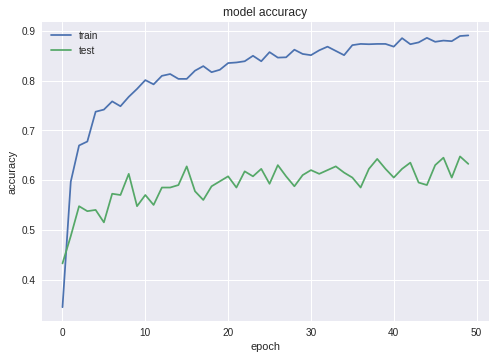

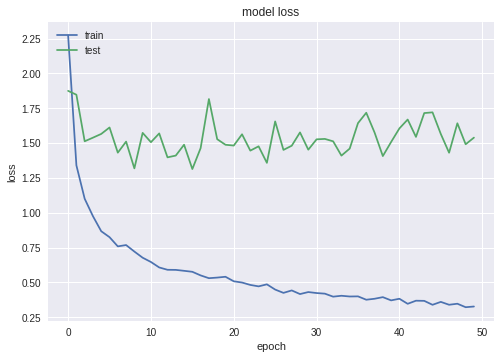

In [18]:
model = get_model()
compile_model(model)
modelFitGenerator(model)

In [15]:
def saveCoreMLModel(kerasModel):
    coreml_model = coremltools.converters.keras.convert(kerasModel,
                                                    input_names=['input'],
                                                    output_names=['probs'],
                                                    image_input_names='input',
                                                    predicted_feature_name='predictedMoney',
                                                    class_labels = 'drive/Resnet2/labels.txt')
    coreml_model.save('resnet50custom.mlmodel') 
    print('CoreML model saved')
    
saveCoreMLModel(model)

0 : input_3, <keras.engine.topology.InputLayer object at 0x7fce5cece940>
1 : conv1_pad, <keras.layers.convolutional.ZeroPadding2D object at 0x7fce5cece128>
2 : conv1, <keras.layers.convolutional.Conv2D object at 0x7fce5cecebe0>
3 : bn_conv1, <keras.layers.normalization.BatchNormalization object at 0x7fce5cece5f8>
4 : activation_99, <keras.layers.core.Activation object at 0x7fce5cecef28>
5 : max_pooling2d_3, <keras.layers.pooling.MaxPooling2D object at 0x7fce5cf1d898>
6 : res2a_branch2a, <keras.layers.convolutional.Conv2D object at 0x7fce5cf1d3c8>
7 : bn2a_branch2a, <keras.layers.normalization.BatchNormalization object at 0x7fce3d98b438>
8 : activation_100, <keras.layers.core.Activation object at 0x7fce3d94e1d0>
9 : res2a_branch2b, <keras.layers.convolutional.Conv2D object at 0x7fce3d9237b8>
10 : bn2a_branch2b, <keras.layers.normalization.BatchNormalization object at 0x7fce3d923048>
11 : activation_101, <keras.layers.core.Activation object at 0x7fce3d86f0b8>
12 : res2a_branch2c, <keras.

In [0]:
# from google.colab import files
# files.download('resnet50custom.mlmodel') 

In [0]:
uploaded = drive.CreateFile()
uploaded.SetContentFile('resnet50custom.mlmodel')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))